# Computer Vision - Project
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm

Constants

In [2]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
db = h5py.File(FILE_NAME, 'r')
SIZE=224


In [3]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [4]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Open Sans':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Titillium Web':
        return 3
    else:
        return 4

In [5]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Open Sans'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Titillium Web'
    else:
        return b'Ubuntu Mono'

In [6]:

def prepare_img(img, bbs, index, size):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [7]:
from pathlib import Path
def create_dirs(main_directory):
    Path(main_directory).mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Sansation').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Open Sans').mkdir(parents=True, exist_ok=True)
    Path(main_directory+'/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [8]:
def get_image_data(db, im):
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    return img, fonts, txts, charBBs, wordBBs

In [9]:
def is_num_or_letter(inp):
    # res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # # print(chr(inp)+"="+str(res))
    if(inp==ord('.') or inp==ord(':')):
        return False
    return True

In [10]:
def crop_and_save(img, BBs, indx, size, curr_font, im, num, do_save=False, folder='main_directory/'):
    cropped = prepare_img(img, BBs, indx, size)
    path = folder+curr_font.decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
    if do_save:
        tf.keras.utils.save_img(path,cropped)
    # print(curr_font)
    # plt.imshow(cropped)
    # plt.show()
    return cropped

In [18]:
def get_data_set(db, size: int):   
    create_dirs('main_directory')
    im_names = list(db['data'].keys())
    num = 0
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            if(j%8!=0):
                curr_font = fonts[font_indx]
                crop_and_save(img, wordBBs, j, size, curr_font, im, num, True)
                num+=1
                for k in range(0, len(txts[j])):
                    if(is_num_or_letter(txts[j][k])):
                        crop_and_save(img, charBBs, char_indx, size, curr_font, im, num, True)
                        num+=1
                    char_indx+=1
            else:
                char_indx+=len(txts[j])
            font_indx += len(txts[j])
    print(num)

In [13]:
from download_h5py_db import download_h5py_db
if not Path("main_directory").exists():
    download_h5py_db()
    get_data_set(db, SIZE)
# train_x, train_y = 

In [14]:
import splitfolders
if not Path("main_directory_splitted").exists():
    splitfolders.ratio("main_directory/", # The location of dataset
                   output="main_directory_splitted", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .1, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

In [29]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     #,validation_split=0.25
     )
    # Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory_splitted/train/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory('main_directory_splitted/val/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    test_it = datagen_val.flow_from_directory('main_directory_splitted/test/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    return it, val_it,test_it, datagen

In [16]:
it, val_it,test_it, datagen = data_augmentation()

Found 24045 images belonging to 5 classes.
Found 3003 images belonging to 5 classes.
Found 3010 images belonging to 5 classes.


Found 27011 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.

In [22]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from keras import regularizers

num_classes = 5
input_size= SIZE

baseModel = tf.keras.applications.ResNet50(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = GaussianNoise(0.1)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="res/top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [24]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
# if not os.path.isfile('model_res.h5'):
history = model.fit(it, epochs=25, shuffle=True, validation_data=val_it, verbose=1
            ,callbacks=callbacks_list
            )
# else:
#   model = tf.keras.models.load_model('model_res.h5')

Epoch 1/25
1336/1336 [==============================] - ETA: 0s - loss: 5.1323 - accuracy: 0.4195
Epoch 1: val_loss improved from inf to 3.97772, saving model to res\top_model.h5
1336/1336 [==============================] - 436s 322ms/step - loss: 5.1323 - accuracy: 0.4195 - val_loss: 3.9777 - val_accuracy: 0.5305
Epoch 2/25
1336/1336 [==============================] - ETA: 0s - loss: 3.1119 - accuracy: 0.5691
Epoch 2: val_loss improved from 3.97772 to 2.40442, saving model to res\top_model.h5
1336/1336 [==============================] - 433s 324ms/step - loss: 3.1119 - accuracy: 0.5691 - val_loss: 2.4044 - val_accuracy: 0.5931
Epoch 3/25
1336/1336 [==============================] - ETA: 0s - loss: 1.9419 - accuracy: 0.6264
Epoch 3: val_loss improved from 2.40442 to 1.54035, saving model to res\top_model.h5
1336/1336 [==============================] - 453s 339ms/step - loss: 1.9419 - accuracy: 0.6264 - val_loss: 1.5403 - val_accuracy: 0.6617
Epoch 4/25
1336/1336 [======================

In [12]:
model = tf.keras.models.load_model('res\\top_model.h5')

In [62]:
score = model.evaluate(val_it)

167/167 [==============================] - 14s 81ms/step - loss: 0.5123 - accuracy: 0.8182


In [38]:
score = model.evaluate(test_it)

168/168 [==============================] - 15s 80ms/step - loss: 0.5038 - accuracy: 0.8203


In [ ]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.4731270968914032 / Test accuracy: 0.8367893099784851


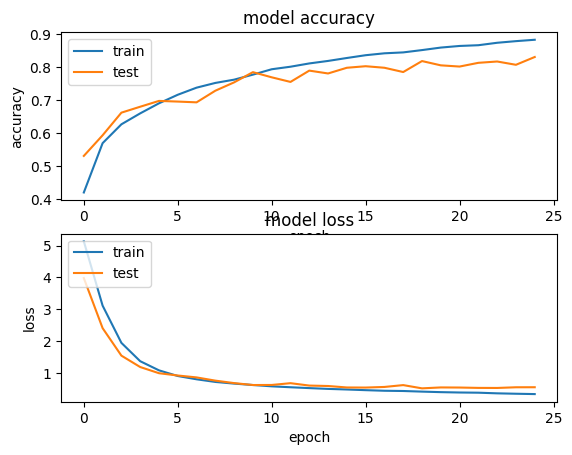

In [26]:
draw_training_curve(history)

In [ ]:
# model.save('model_res')

INFO:tensorflow:Assets written to: model_res\assets


INFO:tensorflow:Assets written to: model_res\assets


In [39]:
model = tf.keras.models.load_model('model_res_')

In [13]:
from sklearn.preprocessing import normalize
create_dirs('test_t')
size=SIZE
im_names = list(db['data'].keys())
num = 0
# prediction_arr=[]
# test_y = []
test_x_total = []
test_y_total = []

for i in tqdm(range(0, int((len(im_names)-1)/4))):
    im = im_names[i]
    img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
    font_indx = 0 
    char_indx = 0
    
    # print(im)
    for j in range(0, len(txts)):
        if(j%8==0): 
            curr_font = fonts[font_indx]
            # test_x = [] 
            cropped = crop_and_save(img, wordBBs, j, size, curr_font, im, num,True,'test_t/')
            # test_x.append(cropped)
            test_x_total.append(cropped)
            test_y_total.append(font_to_num(curr_font))
            num+=1            
            for k in range(0, len(txts[j])):
                # if(is_num_or_letter(txts[j][k])):
                cropped = crop_and_save(img, charBBs, char_indx, size, curr_font, im, num,True,'test_t/')
                # test_x.append(cropped)
                test_x_total.append(cropped)
                test_y_total.append(font_to_num(curr_font))
                    # test_y.append(font_to_num(curr_font))
                num+=1
                char_indx+=1
            # test_x = np.asarray(test_x, dtype=np.float32)
            # # for im in test_x:
            # #     plt.imshow(im)
            # #     plt.show()
            # # # print(test_x)
            # reses = model.predict(test_x, verbose=0)
            # # print(reses)
            # # print(maxes)
            # maxes = np.argmax(reses, axis=1)
            # # print(np.bincount(maxes))
            # prediction = np.bincount(maxes)
            # prediction = np.argwhere(prediction==prediction.max())
            # if (len(prediction)>1):
            #     sum_p = reses.sum(axis=0)
            #     prediction = sum_p.argmax()

            #     if(font_to_num(curr_font)!=prediction):
            #         # print(sum_p)
            #         reses_n = normalize(reses, axis=1, norm='l1')
            #         maxes_n = np.argmax(reses_n, axis=1)
            #         # print(np.bincount(maxes))
            #         prediction = np.bincount(maxes_n)
            #         prediction = np.argmax(prediction)
            #         if(font_to_num(curr_font)!=prediction):
            #             sum_p = np.sum(reses, axis=0)
            #             prediction = sum_p.argmax()
            #         # # print(reses[0]/np.sum(reses, axis=1)[0])
            #         #     print(maxes)
            #         # print(prediction)
            #         # plt.imshow(test_x[0])
            #         # plt.show()
            # # print(prediction)
            #         # print(font_to_num(fonts[font_indx]))
            # for k in range(0, len(txts[j])):
            #     test_y.append(font_to_num(curr_font))
            #     # prediction_arr.append(prediction.item())
            #     # print(prediction.item())
            #     prediction_arr.append(maxes[k+1])
            # if(font_to_num(curr_font)!=prediction):
            #     plt.imshow(test_x[0])
            #     plt.show()
            #     print(maxes)
            #     print(reses)
            #     print(prediction)
            #     print(font_to_num(fonts[font_indx]))
            #     print('----------------------')
            # print(num_to_font(prediction))
            # print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])
test_x_total = np.asarray(test_x_total, dtype=np.float32)
pred_y_total = model.predict(test_x_total)


100%|██████████| 249/249 [00:08<00:00, 28.01it/s]


55/55 [==============================] - 9s 95ms/step


In [50]:
# print(len(prediction_arr))
# print(len(test_y))
# test_x = np.asarray(test_x, dtype=np.float32)

837
837


In [25]:
# for i,im in enumerate(test_x_total):
#     plt.imshow(im)
#     plt.show()
#     print(test_y_total[i])
#     print(pred_y_total[i])

In [17]:
pred_y_total=np.argmax(pred_y_total, axis=1)

In [18]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y_total, pred_y_total, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.54      0.96      0.69       327
    Open Sans       0.59      0.47      0.53       320
    Sansation       0.63      0.55      0.59       376
Titillium Web       0.75      0.60      0.67       363
  Ubuntu Mono       0.89      0.73      0.80       374

     accuracy                           0.66      1760
    macro avg       0.68      0.66      0.65      1760
 weighted avg       0.69      0.66      0.66      1760



In [37]:
datagen_t =  ImageDataGenerator( 
     rescale=1/255,dtype='float32')
it_t = datagen_t.flow_from_directory('test_t', class_mode='categorical',
    shuffle=False)

Found 3534 images belonging to 5 classes.


In [38]:
model.evaluate(it_t)

111/111 [==============================] - 15s 133ms/step - loss: 0.6904 - accuracy: 0.7589


[0.6903998255729675, 0.7589133977890015]

In [ ]:
# y_pred=np.argmax(prediction_arr, axis=1)

In [57]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.59      0.96      0.73       169
    Open Sans       0.58      0.51      0.54       142
    Sansation       0.71      0.56      0.63       208
Titillium Web       0.76      0.67      0.71       158
  Ubuntu Mono       0.89      0.74      0.81       160

     accuracy                           0.69       837
    macro avg       0.71      0.69      0.68       837
 weighted avg       0.71      0.69      0.68       837



In [ ]:
print(len(test_x))

1003


In [ ]:
prediction_arr = model.predict(test_x)

32/32 [==============================] - 4s 105ms/step


In [ ]:
y_pred=np.argmax(prediction_arr, axis=1)
# y_test=np.argmax(test_y_cat, axis=1)

In [ ]:
test_y = np.asarray(test_y, dtype=np.float32)

In [ ]:
test_y_cat = np_utils.to_categorical(test_y, 5)

In [ ]:
# print(test_y)
print(test_y.shape)

(1003,)


In [ ]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Open Sans','Titillium Web','Sansation','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

In [ ]:
# for im in test_x:
#     tf.keras.utils.save_img('path',cropped)

In [30]:
datagen_try =  ImageDataGenerator(
     rescale=1/255, dtype='float32',
     )
it_try = datagen_try.flow(test_x,y_pred,'test_set/', shuffle=False)

In [ ]:
pted_try = model.predict(it_try)

32/32 [==============================] - 3s 107ms/step


In [ ]:
y_pred=np.argmax(prediction_arr, axis=1)

In [ ]:
print(classification_report(test_y, y_pred, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.80      0.93      0.86       204
Titillium Web       0.14      0.12      0.13       195
    Sansation       0.73      0.68      0.70       248
    Open Sans       0.13      0.14      0.13       168
  Ubuntu Mono       0.81      0.82      0.81       188

     accuracy                           0.56      1003
    macro avg       0.52      0.54      0.53      1003
 weighted avg       0.54      0.56      0.55      1003



In [ ]:
datagen_t =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t_it = datagen_t.flow_from_directory('check_test', batch_size=18, class_mode='categorical',shuffle=False
#save_to_dir='augmented',
    )

Found 3850 images belonging to 5 classes.


In [ ]:
score = model.evaluate(t_it)

214/214 [==============================] - 15s 68ms/step - loss: 0.6127 - accuracy: 0.7730


In [ ]:
predict = model.predict(t_it)

214/214 [==============================] - 14s 64ms/step


In [ ]:
# get the class with highest probability for each sample
y_pred = np.argmax(predict, axis=-1)

In [ ]:
print(classification_report(t_it.classes, y_pred, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.88      0.91      0.90       818
Titillium Web       0.55      0.60      0.57       547
    Sansation       0.74      0.72      0.73       910
    Open Sans       0.75      0.61      0.68       732
  Ubuntu Mono       0.86      0.95      0.90       843

     accuracy                           0.77      3850
    macro avg       0.76      0.76      0.76      3850
 weighted avg       0.77      0.77      0.77      3850



In [ ]:
# prediction_arr_cat = np_utils.to_categorical(prediction_arr, 5)
# test_y_cat = np_utils.to_categorical(test_y, 5)

In [ ]:
# import tensorflow as tf

# m = tf.keras.metrics.AUC()

# m.update_state(test_y, prediction_arr) # assuming both have shape (N,)

# r = m.result().numpy()

# print(r)

In [ ]:
# y_true = test_y_cat
# y_pred = prediction_arr
# kacc = tf.keras.metrics.Accuracy()
# _ = kacc.update_state(y_true, y_pred)
# print(f'Keras Accuracy acc: {kacc.result().numpy()*100:.3}')

# kbacc = tf.keras.metrics.BinaryAccuracy()
# _ = kbacc.update_state(y_true, y_pred)
# print(f'Keras BinaryAccuracy acc: {kbacc.result().numpy()*100:.3}')

# print(f'SkLearn acc: {accuracy_score(y_true, y_pred)*100:.3}')